# Value class

In [32]:
import math

In [57]:
class Value:

    def __init__(self, data, _children = (), _op = '', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        
        return out

    def __rmul__(self, other): # performing other * self
        return self * other

    def __truediv__(self, other): # performing self / other
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/ float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * self.data**(other - 1) * out.grad

        out._backward = _backward

        return out

    def __neg__(self): # performing -self
        return self * -1

    def __sub__(self, other): # performing self - other
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [23]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d*f; L.label = 'L'
L

Value(data=-8.0)

In [24]:
d._prev, d._op

({Value(data=-6.0), Value(data=10.0)}, '+')

In [25]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)

    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr = {'rankdir':'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad ), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

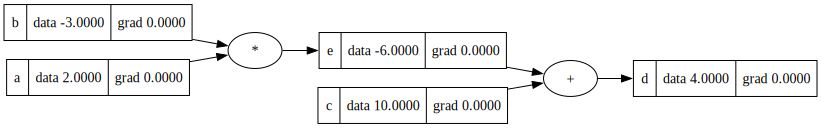

In [26]:
draw_dot(d)

# Example

$$\sum_{i}w_{i}x_{i} + b $$

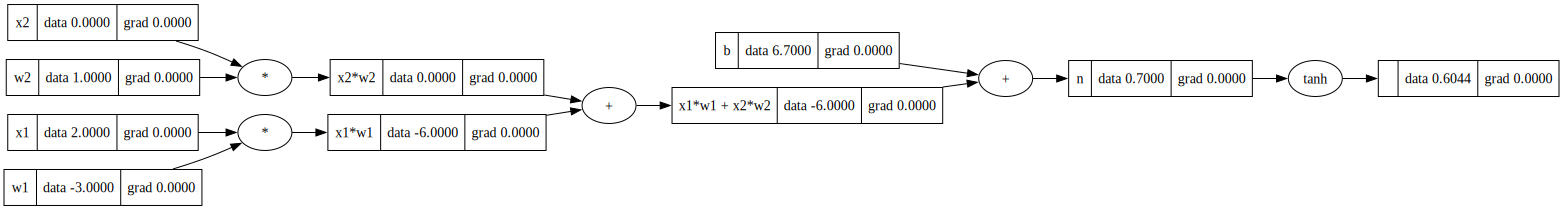

In [41]:
# inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

# weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# bias of the neuron
b = Value(6.7, label = 'b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh()
draw_dot(o)

## Do the backward propagation

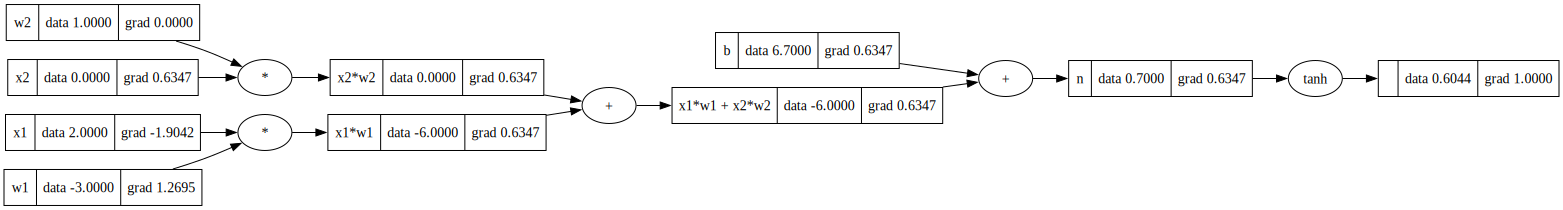

In [36]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

draw_dot(o)

## Topological Sort

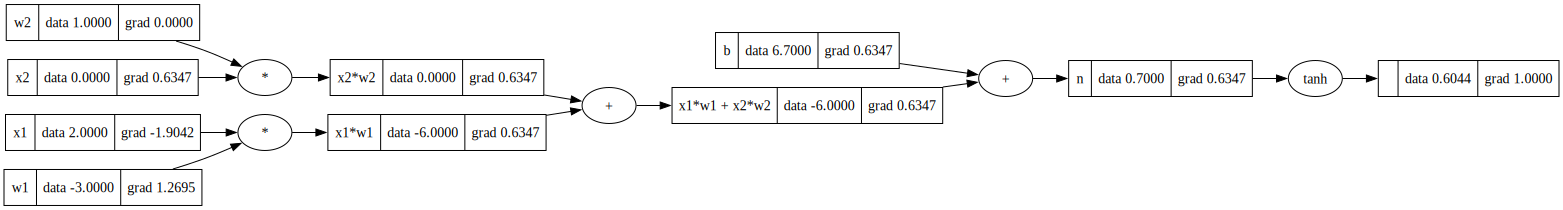

In [38]:
draw_dot(o)

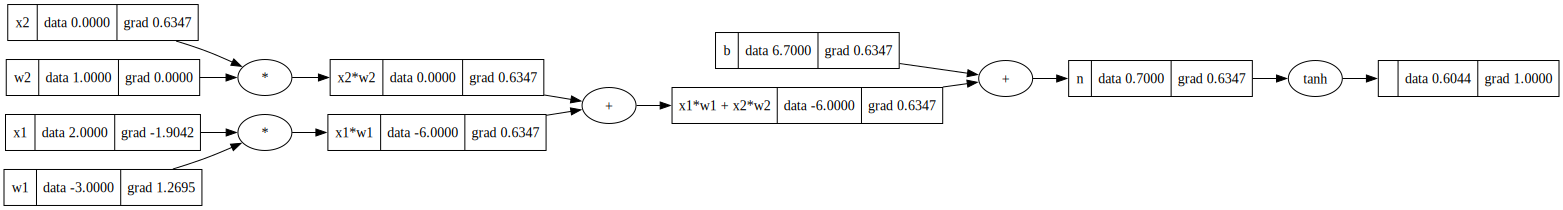

In [42]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)

for node in reversed(topo):
    node._backward()

draw_dot(o)

# Some bug

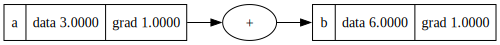

In [45]:
a = Value(3.0, label = 'a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

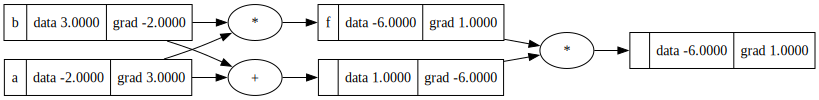

In [47]:
a = Value(-2.0, label = 'a')
b = Value(3.0, label = 'b')
d = a*b; d.label = 'd'
e = a+b; d.label = 'e'
f = d*e; d.label = 'f'

# f = (a*b)(a+b) = ba^2 + ab^2

f.backward()

draw_dot(f)

We need to accumulate the gradient<br>

after we accumulate the gradiend

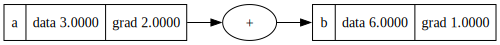

In [49]:
a = Value(3.0, label = 'a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

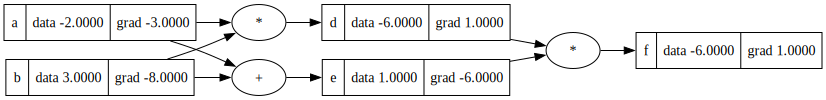

In [51]:
a = Value(-2.0, label = 'a')
b = Value(3.0, label = 'b')
d = a*b; d.label = 'd'
e = a+b; e.label = 'e'
f = d*e; f.label = 'f'

# f = (a*b)(a+b) = ba^2 + ab^2
# df/da = 2ab + b^2 = -12 + 9 = -3
# df/db = a^2 + 2ab = 4 + -12 = -8

f.backward()

draw_dot(f)

# Break tanh into more small operation

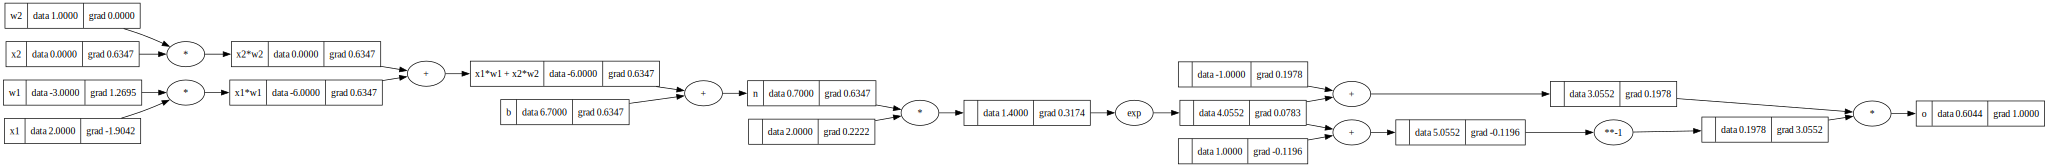

In [59]:
# inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

# weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# bias of the neuron
b = Value(6.7, label = 'b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ---
e = (2*n).exp()
o = (e - 1)/(e+1)
o.label = 'o'
# ---

o.backward()
draw_dot(o)

# using pytorch

In [70]:
import torch

In [72]:
x1 = torch.Tensor([2.0]).double();x1.requires_grad = True   
x2 = torch.Tensor([0.0]).double();x2.requires_grad = True   
w1 = torch.Tensor([-3.0]).double();w1.requires_grad = True   
w2 = torch.Tensor([1.0]).double();w2.requires_grad = True   
b = torch.Tensor([6.7]).double();b.requires_grad = True   
n = x1*w1 + x2*w2 + b 
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---")
print("x1", x1.grad.item())
print("x2", x2.grad.item())
print("w1", w1.grad.item())
print("w2", w2.grad.item())

0.6043676560501806
---
x1 -1.9042192089612318
x2 0.6347397363204106
w1 1.2694794726408212
w2 0.0
